In [1]:
import pennylane as qml
import networkx as nx
from pennylane import numpy as np

import matplotlib.pyplot as plt

from pennylane.transforms import decompose
from functools import partial

In [2]:
import warnings

# Filter out all warnings
warnings.filterwarnings("ignore")

In [3]:
# Define the Max-Cut QAOA class
class MaxCut_QAOA:
    def __init__(self, graph, p=1, device=None, allowed_gates=None):        
        # Initialize the graph and problem parameters
        self.graph = graph
        self.nodes = sorted(set([node for edge in graph.keys() for node in edge]))
        self.n_qubits = len(set(node for edge in graph.keys() for node in edge))
        self.p = p  # number of QAOA layers
        self.shape = qml.QAOAEmbedding.shape(self.p, n_wires=self.n_qubits)
        self.device = device if device else qml.device('default.qubit', wires=self.n_qubits)

        # pick your basis / allowed gate set (can be names or Op classes)
        if allowed_gates is None:
            allowed_gates = {qml.RX, qml.RZ, qml.CNOT}  # example

        # build a decomposed version of the ansatz and wrap it in a QNode
        decomp = partial(qml.transforms.decompose, gate_set=allowed_gates)
        self.quantum_node = qml.QNode(decomp(self.variational_ansatz_qaoa), self.device)

    def variational_ansatz_qaoa(self, params):
        # Apply the QAOA ansatz.
        # Create QAOAEmbedding with the graph and weights
        qml.QAOAEmbedding(
            features=self.nodes,  # Graph nodes (qubits)
            weights= params,             # Adjacency matrix (graph edges as weights)
            wires=range(self.n_qubits)  # Each qubit corresponds to a node in the graph
        )
        return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]
    
    def hamiltonian_cost(self, params):
        # Get the quantum values from the quantum node
        quantum_values = self.quantum_node(params)

        cut_cost = 0

        for (i, j), w in self.graph.items():
            # Computation of the Hamiltonian cost using the quantum values measured from the QAOA Circuit
            cut_cost += -0.5 * w * (1 - quantum_values[i] * quantum_values[j])

        return cut_cost
    
    def do_optimization(self, steps=100, restarts=3, step_size=0.02, conv_tol=1e-4):
        """
        Optimize QAOA parameters using the Adam optimizer.
        Tracks best parameters over multiple random restarts.
        """
        opt = qml.AdamOptimizer(stepsize=step_size)
        best_params, best_cost = None, np.inf

        print(f"\nStarting optimization with {restarts} restarts...\n")

        for restart in range(restarts):
            print(f"Restart {restart+1}/{restarts}")
            params = np.random.uniform(0, 0.1, size=self.shape, requires_grad=True)
            prev_cost = np.inf

            for n in range(steps):
                # Use step_and_cost to avoid redundant evaluations
                params, current_cost = opt.step_and_cost(self.hamiltonian_cost, params)
                print(f"  Iter {n+1:03d} | Cost = {current_cost:.6f}")

                # Convergence check
                if np.abs(prev_cost - current_cost) < conv_tol:
                    print(f"Converged at iteration {n+1}")
                    break
                prev_cost = current_cost

            # Track best parameters across restarts
            if current_cost < best_cost:
                best_cost, best_params = current_cost, params.copy()
                print(f"New best cost found: {best_cost:.6f}\n")
            else:
                print(f"  No improvement (best so far: {best_cost:.6f})\n")

        print(f"Optimization complete. Best cost: {best_cost:.6f}\n")
        return best_params

    def draw_graph(self):
        # Build and draw graph
        G = nx.Graph()
        for (u, v), w in self.graph.items():
            G.add_edge(u, v, weight=w)
            
        pos = nx.spring_layout(G, seed=42)
        plt.figure(figsize=(8, 8))
        nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_size=14)
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)
        plt.title("Graph Representation of Max-Cut Problem")
        plt.axis('off')
        plt.savefig("InitialGraph.png", format="PNG", dpi=300, bbox_inches="tight")
        plt.show()

    def quantum_circuit(self):
        qml.drawer.use_style("pennylane")
        fig, ax = qml.draw_mpl(self.quantum_node, expansion_strategy="device")(np.random.uniform(0, np.pi, size=self.shape))
        ax.axis('off')
        plt.title("Quantum Circuit for QAOA Ansatz", fontsize=30)
        plt.tight_layout()
        plt.savefig("QAOA_QuantumCircuit.png", format="PNG", dpi=300, bbox_inches="tight")
        plt.show()        

In [4]:
p = 2

graph = {
    (0, 1): 0.2,
    (1, 2): 0.7,
    (2, 3): 0.6,
    (3, 4): 0.9,
    (4, 5): 0.5,
    (5, 6): 0.3,
    (6, 7): 0.3,
    (7, 8): 0.6,
    (8, 9): 0.7,
    (9, 10): 0.1,
    (10, 11): 0.5,
    (11, 12): 0.9,
    (12, 13): 0.6,
    (13, 14): 0.7,
    (14, 0): 0.8,
    (0, 10): 0.8,
    (2, 12): 0.9,
    (4, 14): 0.9,
    (6, 11): 0.6,
    (8, 13): 0.7,
    (1, 9): 0.6,
    (3, 7): 0.5,
    (5, 12): 0.1
}

In [5]:
# Initialize the MaxCutQAOA instance with the graph
max_cut_qaoa = MaxCut_QAOA(graph=graph, p=p)

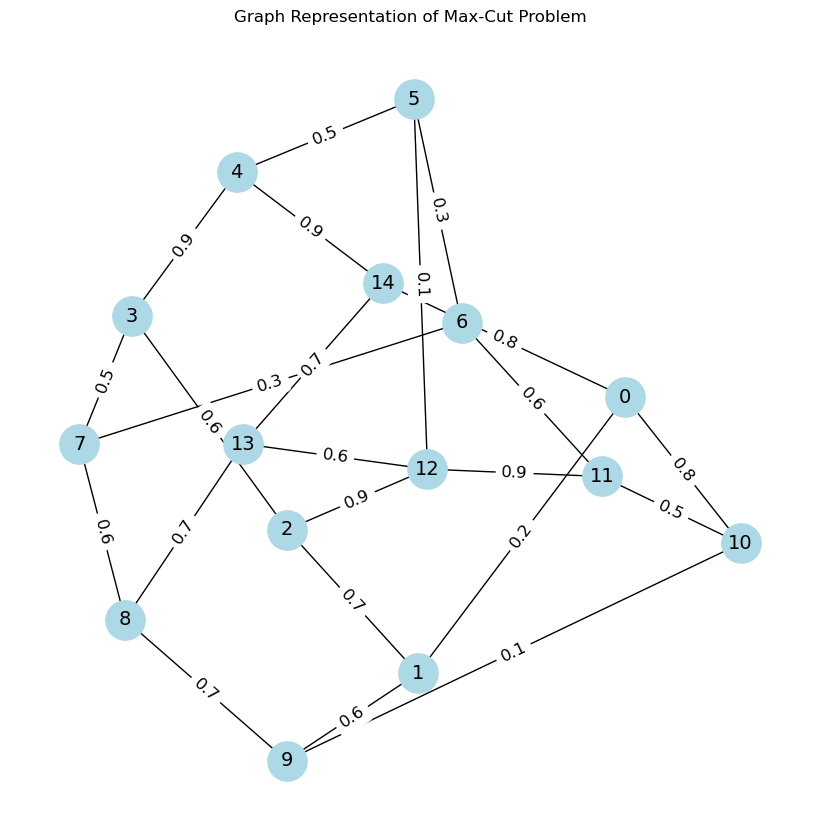

In [6]:
# # Draw the graph representation
max_cut_qaoa.draw_graph()

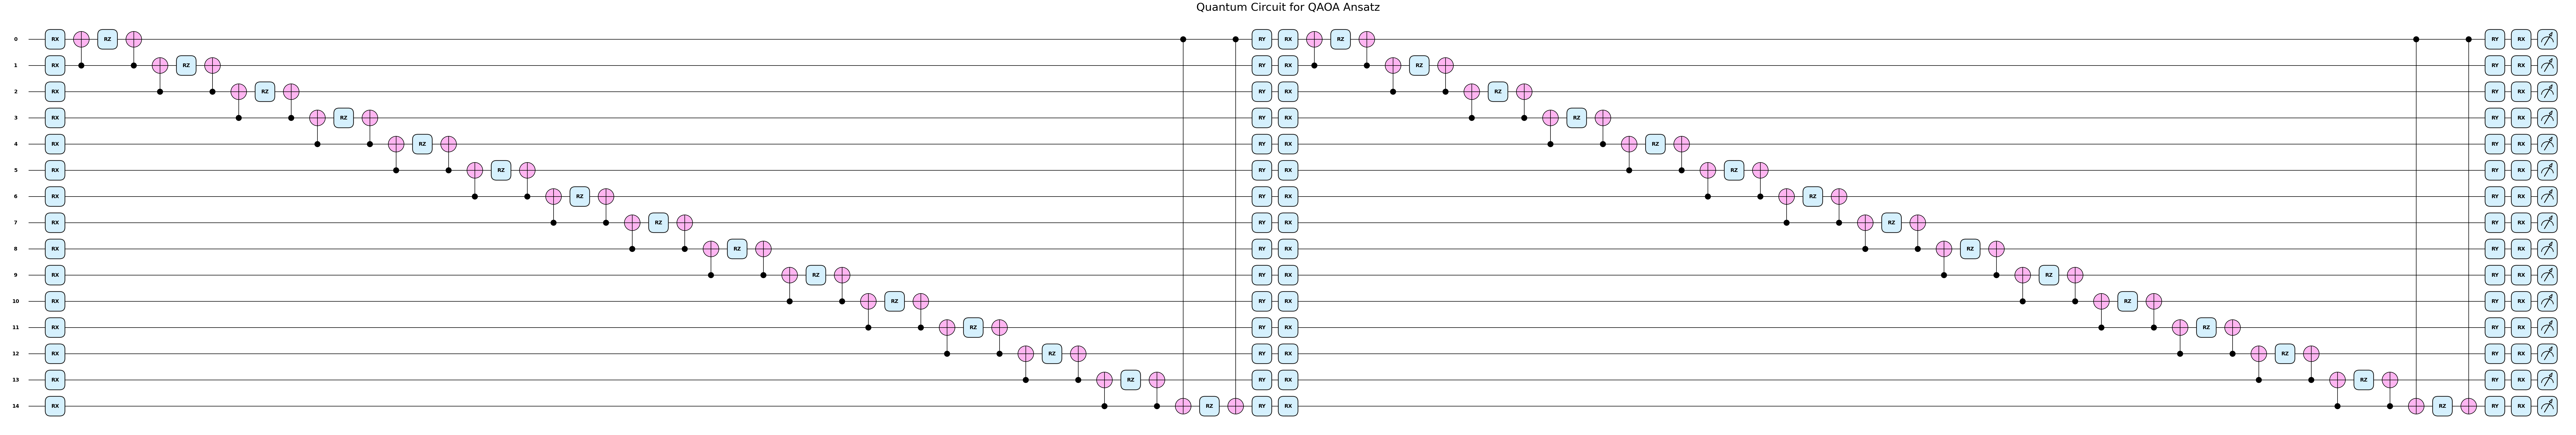

In [7]:
# Draw the quantum circuit
max_cut_qaoa.quantum_circuit()

In [8]:
# Optimize the QAOA parameters
# Run the optimization to get the optimized parameters
optimal_params = max_cut_qaoa.do_optimization(steps=200)


Starting optimization with 3 restarts...

Restart 1/3
  Iter 001 | Cost = -8.260730
  Iter 002 | Cost = -8.288746
  Iter 003 | Cost = -8.306938
  Iter 004 | Cost = -8.321579
  Iter 005 | Cost = -8.336628
  Iter 006 | Cost = -8.352616
  Iter 007 | Cost = -8.369954
  Iter 008 | Cost = -8.389516
  Iter 009 | Cost = -8.412248
  Iter 010 | Cost = -8.438590
  Iter 011 | Cost = -8.468341
  Iter 012 | Cost = -8.500980
  Iter 013 | Cost = -8.536074
  Iter 014 | Cost = -8.573479
  Iter 015 | Cost = -8.613337
  Iter 016 | Cost = -8.655953
  Iter 017 | Cost = -8.701590
  Iter 018 | Cost = -8.750344
  Iter 019 | Cost = -8.802148
  Iter 020 | Cost = -8.856858
  Iter 021 | Cost = -8.914312
  Iter 022 | Cost = -8.974283
  Iter 023 | Cost = -9.036430
  Iter 024 | Cost = -9.100331
  Iter 025 | Cost = -9.165539
  Iter 026 | Cost = -9.231542
  Iter 027 | Cost = -9.297657
  Iter 028 | Cost = -9.363042
  Iter 029 | Cost = -9.426784
  Iter 030 | Cost = -9.487972
  Iter 031 | Cost = -9.545742
  Iter 032 | Co

In [9]:
# Print the optimal parameters found by the optimizer
print(f"Optimal parameters: {optimal_params}")

Optimal parameters: [[-1.43874632e-01  4.83730780e-01  1.39286589e+00  4.08732671e-01
   1.59573105e-02  1.05312706e+00  7.28881183e-01 -1.88122551e+00
  -2.16239533e-01 -8.19939619e-01 -1.56905777e+00 -4.05409951e-03
  -4.48301186e-01  1.31474862e+00  8.10402062e-04 -1.44808549e-06
   1.65697606e+00 -3.94974014e-01  1.80244280e+00  1.42308962e+00
   1.84886692e+00  1.93607351e-01 -1.09820231e+00  1.30832407e+00
  -8.93668101e-01 -5.66083336e-01  1.07900602e+00  1.04473060e+00
   2.56945816e+00 -8.09420157e-01]
 [-4.67191953e-01  4.17105457e-01 -1.19359702e-01 -2.50720335e-02
  -1.17734228e-02  5.93222245e-01 -8.17409563e-01  7.18372304e-01
  -1.47895481e-02  4.12595547e-02  2.41893455e+00 -8.59733014e-04
  -1.15127887e-03 -6.43248182e-01 -1.06933135e+00 -5.89868112e-07
   4.74645476e-01 -1.44076731e+00  1.85088454e+00 -1.15108602e+00
  -1.63262641e-01  2.70647176e+00  1.07309863e+00  1.29366904e+00
   1.83422835e+00  7.98410651e-01  1.79373369e+00  1.50542147e+00
  -2.48604482e+00  2.

In [10]:
# Sampling with optimal params

shots = 8192
n_qubits = len(set(node for edge in graph.keys() for node in edge))
dev = qml.device("default.qubit", wires=n_qubits, shots=shots)

features = sorted(set([node for edge in graph.keys() for node in edge]))
allowed_gates = {qml.RX, qml.RZ, qml.CNOT}  # example

@partial(decompose, gate_set=allowed_gates)
@qml.qnode(dev)
def sample_circuit(weights, shots=shots):
    qml.QAOAEmbedding(features=features, weights=weights, wires=range(n_qubits))
    return qml.sample()

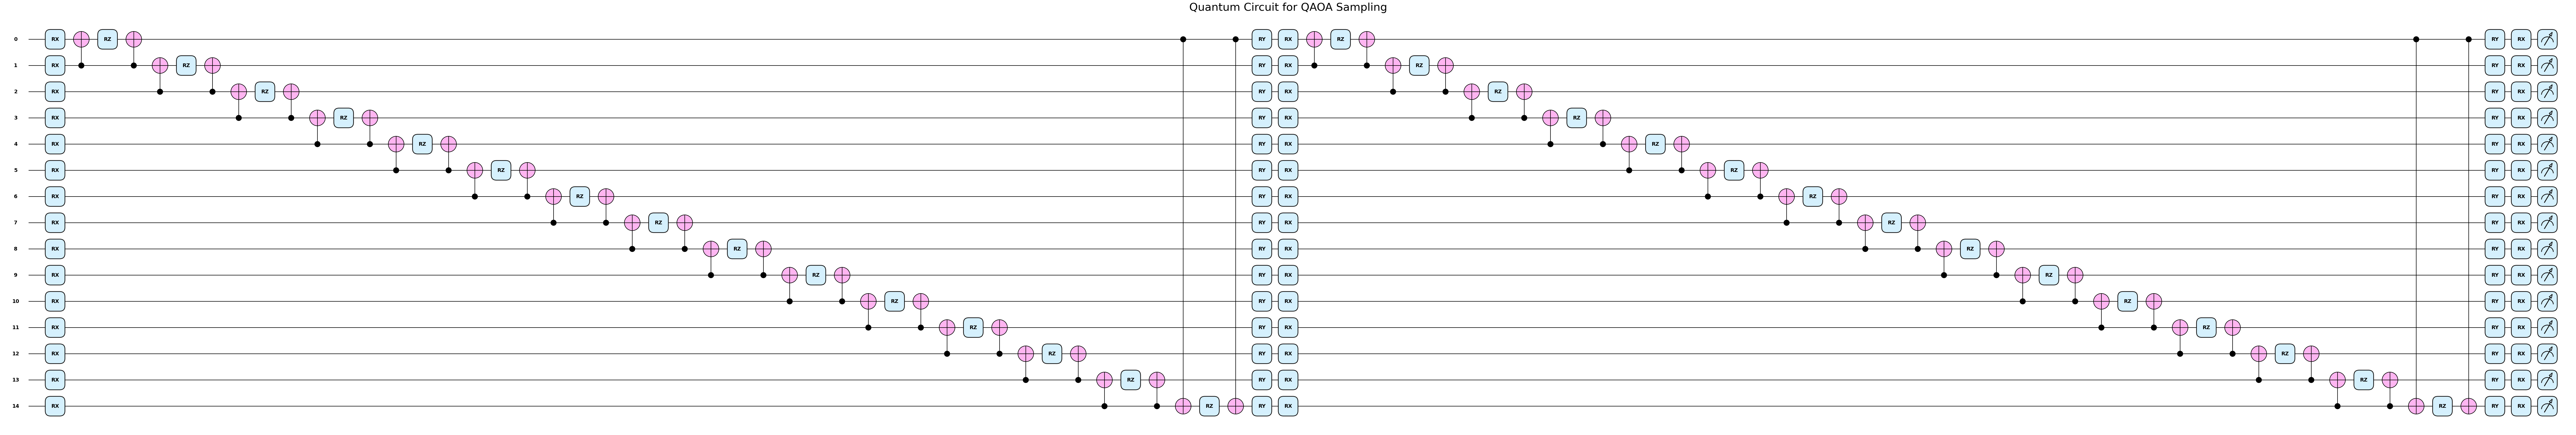

In [11]:
qml.drawer.use_style("pennylane")

shape = qml.QAOAEmbedding.shape(p, n_wires=n_qubits)
fig, ax = qml.draw_mpl(sample_circuit, expansion_strategy="device")(optimal_params)
ax.axis('off')
plt.title("Quantum Circuit for QAOA Sampling", fontsize=30)
plt.tight_layout()
plt.show()     

In [12]:
samples = sample_circuit(optimal_params, shots=shots)

def cut_value(bitstring, graph):
    value = 0

    for (i, j), w in graph.items():
        if bitstring[i] != bitstring[j]:
            value += w
    return value

# Find best bitstring
best_sample, best_value = None, -np.inf
for s in samples:
    score = cut_value(s, graph)
    if score > best_value:
        best_value, best_sample = score, s.copy()

print("Best bitstring:", best_sample)
print("Max-Cut value:", best_value)

Best bitstring: [0 1 0 1 0 1 1 0 1 0 1 0 1 0 1]
Max-Cut value: 13.1


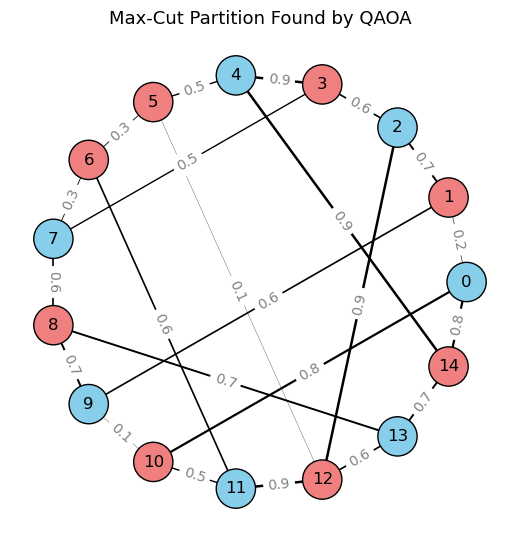

In [13]:
# Solution Visualization

G = nx.Graph()
for (u, v), w in graph.items():
    G.add_edge(u, v, weight=w)

colors = ["lightcoral" if bit else "skyblue" for bit in best_sample]
pos = nx.circular_layout(G)

plt.figure(figsize=(5, 5))
nx.draw(
    G, pos, with_labels=True,
    node_color=colors, node_size=800, font_color="black",
    width=[2*w['weight'] for _,_,w in G.edges(data=True)],
    edgecolors="black"
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={(i,j): f"{w['weight']:.1f}" for i,j,w in G.edges(data=True)},
    font_color="gray"
)
plt.title("Max-Cut Partition Found by QAOA", fontsize=13)
plt.axis("off")
plt.savefig("MaxCut-solution.png", format="PNG", dpi=300, bbox_inches="tight")
plt.show()